In [4]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## Basis Functions

We're going to investigate how to use linear regression to approximate and estimate complicated functions.  For example, suppose we want to fit the following function on the interval $[0,1]$:

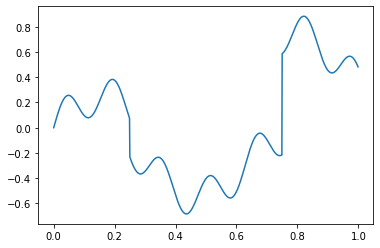

In [5]:
def y(x):
    ret = .15*np.sin(40*x) 
    ret = ret + .25*np.sin(10*x)
    step_fn1 = np.zeros(len(x))
    step_fn1[x >= .25] = 1
    step_fn2 = np.zeros(len(x))
    step_fn2[x >= .75] = 1
    ret = ret - 0.3*step_fn1 + 0.8 *step_fn2 
    return ret

x = np.arange(0.0, 1.0, 0.001)
plt.plot(x, y(x))
plt.show()


Here the input space, shown on the x-axis, is very simple -- it's just the interval $[0,1]$.  The output space is reals ($\mathcal{R}$), and a graph of the function $\{(x,y(x)) \mid x \in [0,1]\}$ is shown above.  Clearly a linear function of the input will not give a good approximation to the function.  There are many ways to construct nonlinear functions of the input.  Some popular approaches in machine learning are regression trees, neural networks, and local regression (e.g. LOESS).  However, our approach here will be to map the input space $[0,1]$ into a "feature space" $\mathcal{R}^d$, and then run standard linear regression in the feature space. 

Feature extraction, or "featurization", maps an input from some input space $\mathcal{X}$ to a vector in $\mathcal{R}^d$.  Here our input space is $\mathcal{X}=[0,1]$, so we could write our feature mapping as a function $\Phi:[0,1]\to\mathcal{R}^d$. The vector $\Phi(x)$ is called a feature vector, and each entry of the vector is called a feature.  Our feature mapping is typically defined in terms of a set of functions, each computing a single entry of the feature vector.  For example, let's define a feature function $\phi_1(x)=1(x\ge0.25)$.  The $1(\cdot)$ denotes an indicator function, which is 1 if the expression in the parenthesis is true, and 0 otherwise.  So $\phi_1(x)$ is $1$ if $x\ge0.25$ and $0$ otherwise.  This function produces a "feature" of x.  Let's define two more features: $\phi_2(x)=1(x\ge0.5)$ and $\phi_3(x)=1(x\ge0.75)$. Now we can define a feature mapping into $\mathcal{R}^3$ as:
$$ \Phi(x) = ( \phi_1(x), \phi_2(x), \phi_3(x) ).$$

Let's code up these feature functions explicitly and plot them as functions of $x$:


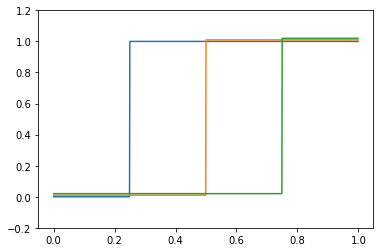

In [6]:
def step_fn_generator(step_loc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= step_loc] = 1
        return ret
    return f

phi_1 = step_fn_generator(0.25)
phi_2 = step_fn_generator(0.50)
phi_3 = step_fn_generator(0.75)

x = np.arange(0.0, 1.0, 0.001)

plt.plot(x, phi_1(x)) 
plt.plot(x, phi_2(x)+.01) #adding perturbation .01 so we the plots don't overlap
plt.plot(x, phi_3(x)+.02) 
plt.ylim([-.2,1.2])
plt.show()

In the plot above we see graphs of the 3 feature functions we defined. We note that feature functions in this context are often called "basis functions" (See Hastie et al's ESL Section 5.1).  You should convince yourself that the feature mapping $\Phi(x)$ only takes on 4 different values as $x$ ranges over the input space $[0,1]$.  For example, the input $0.4$ gets mapped to the vector $(1,0,0)$ under $\Phi$, since $\Phi(0.4) =( \phi_1(0.4), \phi_2(0.4),\phi_3(0.4) )= (1,0,0)$.  

On one hand, the featurization loses a lot of information that was originally contained in the input $x$. (e.g. every input value in the interval $(.25,.5)$ gets mapped to the same feature vector.  On the other hand, affine combinations (i.e. linear combinations plus a constant) of our feature functions can now produce highly nonlinear functions of $x$, as we see in the plots below:

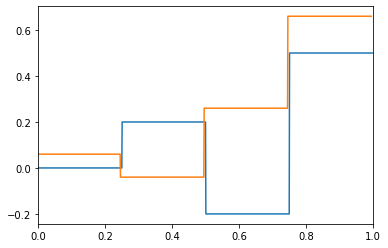

In [7]:
def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

Phi = [phi_1, phi_2, phi_3]
f_1 = linear_comb_generator(Phi, [.2, -.4, .7])
f_2 = linear_comb_generator(Phi, [-.1, .3, .4]) 
plt.plot(x, f_1(x)) 
plt.plot(x-.005, f_2(x)+ .06)  #-0.005 just so easier to view the functions
plt.xlim([0,1])
plt.show()

## Dataset and Feature Transformation 

We will create a basis of step functions on the interval [0,1]. 

In [8]:
def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

We will then construct a linear combination of these step functions to be our target
function. 

In [9]:
def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

We will construct a function to "featurize" an input in [0,1]
into the evaluations of all functions in the basis on the input.

Optionally, if coefs_true is provided, they will be used to generate
target_fn and featurize.

In [10]:
def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize

Data will be generated uniformly randomly between [0,1] as the target function plus noise.

In [11]:
def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

We need to split into training and testing at random

In [12]:
def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

In [13]:
def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

In [14]:
def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

In [15]:
def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])

Putting everything together we can generate and store or load the dataset.

In [ ]:
def main(LOAD_PROBLEM=True, GENERATE_PROBLEM=False, WRITE_PROBLEM=False, path = "lasso_data.pickle" ):
    lasso_data_fname = path
    
    if GENERATE_PROBLEM:
        n=1000
        test_frac=.9
        num_basis_fns=400
        num_nonzero=10
        noise_scale=.25 # scale factor on noise
        tdof = 6 # degrees of freedom of t-distribution generating noise
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

    if LOAD_PROBLEM:
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    fig, ax = plt.subplots()
    plt.scatter(x_train, y_train, s=6, color='k', label='Training data')
    x = np.arange(0,1,.001)
    ax.plot(x, target_fn(x), 'tab:purple', lw=3, label='Target function')
    legend = ax.legend(loc='upper left', shadow=False)
    plt.show(block=False)

main()